**Mounting The Drive To Load Data And Store Models**

In [10]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/TTI/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TTI


**Importing All The Necessary Libraries**

In [11]:
import torch
import torchvision
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from __future__ import print_function
import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
import pdb
import io
from torch.utils.data import Dataset, DataLoader
import h5py
from PIL import Image
import yaml
from torchsummary import summary
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
%matplotlib inline

**Generator Model Class**

In [12]:
class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.img_size = 64
      self.nc = 3
      self.noise_dim = 100
      self.ngf = 64
      self.embed_dim = 1024
      self.projected_embed_dim = 128
      self.latent_dim = self.noise_dim + self.projected_embed_dim
      self.generator = nn.Sequential(
        nn.ConvTranspose2d(self.latent_dim, self.ngf*8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(self.ngf*8),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(self.ngf*8, self.ngf*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ngf*4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(self.ngf*4, self.ngf*2,4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ngf*2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(self.ngf*2, self.ngf,4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ngf),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(self.ngf, self.nc,4, 2, 1, bias = False),
        nn.Tanh()
        )
      
      self.projection = nn.Sequential(
			  nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
			  nn.BatchNorm1d(num_features=self.projected_embed_dim),
			  nn.LeakyReLU(negative_slope=0.2, inplace=True)
			  )
      
    def forward(self, embed_vector, z):
      projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
      latent_vector = torch.cat([projected_embed, z], 1)
      output = self.generator(latent_vector)
      return output

**Testing And Printing Generator Model**

In [13]:
def build_gm():
  gmodel = Generator()
  print(gmodel)
  return gmodel
build_gm();

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

**Discriminator Model Class**

In [14]:
class Concat_embed(nn.Module):

    def __init__(self, embed_dim, projected_embed_dim):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
            nn.BatchNorm1d(num_features=projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)
        return hidden_concat

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.img_size = 64
    self.nc = 3
    self.noise_dim = 100
    self.ndf = 64
    self.embed_dim = 1024
    self.projected_embed_dim = 128
    self.b_dim = 128
    self.c_dim = 64

    self.discriminator1 = nn.Sequential(
        nn.Conv2d(self.nc, self.ndf, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ndf*2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ndf*4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(self.ndf*4, self.ndf*8, 4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ndf*8),
        nn.LeakyReLU(0.2, inplace=True),
        )
    self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)
    self.discriminator2 = nn.Sequential(
        nn.Conv2d(self.ndf*8 + self.projected_embed_dim, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )

  def forward(self, input, embed):
    x_1 = self.discriminator1(input)
    x = self.projector(x_1, embed)
    output = self.discriminator2(x)
    return output.view(-1, 1).squeeze(1), x_1

**Testing And Printing Discriminator Model**

In [15]:
def build_dm():
  dmodel = Discriminator()
  print(dmodel)
  return dmodel
build_dm();

Discriminator(
  (discriminator1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (projector): Concat_embed(
    (projection): Sequential(
      (0): Linear(in_features=1024, out_features=128, b

**Helper Class to Handle and Transform Input Data**

In [16]:
class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        txt = np.array(example['txt']).astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)


**Utility Class to Initialize And Save Model**

In [17]:
class Utils(object):

    @staticmethod
    def smooth_label(tensor, offset):
        return tensor + offset

    @staticmethod
    def save_checkpoint(discriminator, generator, dir_path, subdir_path, epoch):
        path =  os.path.join(dir_path, subdir_path)
        if not os.path.exists(path):
            os.makedirs(path)

        torch.save(discriminator.state_dict(), '{0}/disc_{1}.pth'.format(path, epoch))
        torch.save(generator.state_dict(), '{0}/gen_{1}.pth'.format(path, epoch))

    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

**Reading Input Data/Splitting Data**

In [18]:
traindata = Text2ImageDataset('/content/drive/MyDrive/TTI/flowers.hdf5', split=0)
traindata_loader = DataLoader(traindata, batch_size=64, shuffle=True,
                        num_workers=4)
valdata = Text2ImageDataset('/content/drive/MyDrive/TTI/flowers.hdf5', split=1)
valdata_loader = DataLoader(valdata, batch_size=64, shuffle=True,
                        num_workers=4)
testdata = Text2ImageDataset('/content/drive/MyDrive/TTI/flowers.hdf5', split=2)
testdata_loader = DataLoader(testdata, batch_size=64, shuffle=True,
                        num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
print(len(traindata))

29390


**Visualizing Input Dataset**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


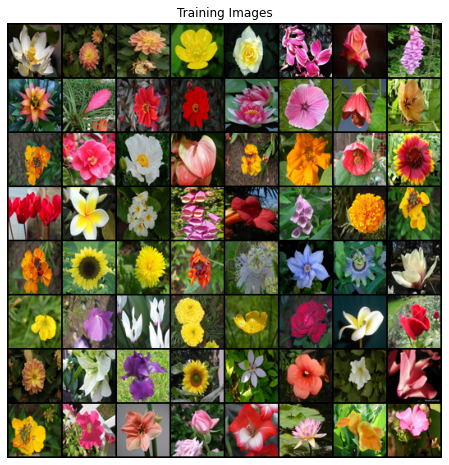

In [20]:
real_batch = next(iter(traindata_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['right_images'].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**Helper Class For Plotting And Logging**

In [21]:
class Helper(object):
  @staticmethod
  def fakePlotter(img_list):
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1].cpu().numpy(),(1,2,0)))
    plt.show()

  @staticmethod    
  def iteration_log(epoch, discriminator_loss, generator_loss, real_score, fake_score):
        print("Epoch: %d, discriminator_loss= %f, generator_loss= %f, D(X)= %f, D(G(X))= %f" % (epoch, discriminator_loss.data.cpu().mean(), generator_loss.data.cpu().mean(), real_score.data.cpu().mean(),fake_score.data.cpu().mean()))

**Loss Functions for Generator and Discriminator**

In [22]:
class generator_loss(torch.nn.Module):
    def __init__(self):
        super(generator_loss, self).__init__()
        self.estimator = nn.BCELoss()

    def forward(self, fake):
        batch_size = fake.size()[0]
        self.labels = Variable(torch.FloatTensor(batch_size).cuda().fill_(1))
        return self.estimator(fake, self.labels)

class discriminator_loss(torch.nn.Module):
    def __init__(self):
        super(discriminator_loss, self).__init__()
        self.estimator = nn.BCELoss()

    def forward(self, real, wrong, fake):
        batch_size = real.size()[0]
        self.real_labels = Variable(torch.FloatTensor(batch_size).cuda().fill_(1))
        self.fake_labels = Variable(torch.FloatTensor(batch_size).cuda().fill_(0))
        return self.estimator(real, self.real_labels) + 0.5 * (self.estimator(wrong, self.fake_labels) + self.estimator(fake, self.fake_labels))


**Main DCGAN Class**

In [23]:
class DCGAN(object):
    def __init__(self, learning_rate, batch_size=64, epochs=1, pre_trained_gen=None, pre_trained_disc=None):

        self.generator = torch.nn.DataParallel(Generator().cuda())
        self.generator.apply(Utils.weights_init)
        self.discriminator = torch.nn.DataParallel(Discriminator().cuda())
        self.discriminator.apply(Utils.weights_init)

        self.noise_dim = 100
        self.l1_coef = 50
        self.l2_coef = 100
        self.beta1 = 0.5

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = epochs
        self.traindata_loader = traindata_loader
        self.valdata_loader = valdata_loader
        self.testdata_loader = testdata_loader

        self.optimize_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))
        self.optimize_generator = torch.optim.Adam(self.generator.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))

        self.checkpoints_path = 'Training/checkpoints'
        self.train_save_path = 'Training/res'
        self.val_save_path = 'Validation/valres'
        self.test_save_path = 'Testing/testres'

    def train_dcgan(self):
        criterion = nn.BCELoss()
        l2_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()
        for epoch in range(self.num_epochs):
            img_list = []
            for sample in self.traindata_loader:
                right_images = sample['right_images']
                right_embed = sample['right_embed']
                wrong_images = sample['wrong_images']

                right_images = Variable(right_images.float()).cuda()
                right_embed = Variable(right_embed.float()).cuda()
                wrong_images = Variable(wrong_images.float()).cuda()

                real_labels = torch.ones(right_images.size(0))
                fake_labels = torch.zeros(right_images.size(0))

                smoothed_real_labels = torch.FloatTensor(Utils.smooth_label(real_labels.numpy(), -0.1))

                real_labels = Variable(real_labels).cuda()
                smoothed_real_labels = Variable(smoothed_real_labels).cuda()
                fake_labels = Variable(fake_labels).cuda()

                # Train the discriminator model
                self.discriminator.zero_grad()
                outputs, activation_real = self.discriminator(right_images, right_embed)
                real_loss = criterion(outputs, smoothed_real_labels)
                real_score = outputs

                noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise)
                outputs, _ = self.discriminator(fake_images, right_embed)
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs

                discriminator_loss = real_loss + fake_loss

                discriminator_loss.backward()
                self.optimize_discriminator.step()

                # Train the generator model
                self.generator.zero_grad()
                noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise)
                outputs, activation_fake = self.discriminator(fake_images, right_embed)
                _, activation_real = self.discriminator(right_images, right_embed)

                activation_fake = torch.mean(activation_fake, 0)
                activation_real = torch.mean(activation_real, 0)

                generator_loss = criterion(outputs, real_labels) + self.l2_coef * l2_loss(activation_fake, activation_real.detach()) + self.l1_coef * l1_loss(fake_images, right_images)

                generator_loss.backward()
                self.optimize_generator.step()
                Helper.iteration_log(epoch,discriminator_loss, generator_loss, real_score, fake_score)
                img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
                Generator_losses.append(generator_loss.item())
                Discriminator_losses.append(discriminator_loss.item())
            Helper.fakePlotter(img_list)
            Utils.save_checkpoint(self.discriminator, self.generator, self.checkpoints_path, self.train_save_path, epoch)

    def train_predict(self):
        for sample in self.traindata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('results/{0}'.format(self.train_save_path)):
                os.makedirs('results/{0}'.format(self.train_save_path))

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('results/{0}/{1}.jpg'.format(self.train_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break
    
    def val_predict(self):
        for sample in self.valdata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('results/{0}'.format(self.val_save_path)):
                os.makedirs('results/{0}'.format(self.val_save_path))

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('results/{0}/{1}.jpg'.format(self.val_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break

    def test_predict(self):
        for sample in self.testdata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('results/{0}'.format(self.test_save_path)):
                os.makedirs('results/{0}'.format(self.test_save_path))

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('results/{0}/{1}.jpg'.format(self.test_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break

**DCGAN Trainer**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0, discriminator_loss= 1.395001, generator_loss= 40.817020, D(X)= 0.480117, D(G(X))= 0.311981
Epoch: 0, discriminator_loss= 2.358166, generator_loss= 39.502670, D(X)= 0.958737, D(G(X))= 0.756696
Epoch: 0, discriminator_loss= 1.229667, generator_loss= 39.142288, D(X)= 0.836218, D(G(X))= 0.414857
Epoch: 0, discriminator_loss= 1.172891, generator_loss= 36.478012, D(X)= 0.557476, D(G(X))= 0.213053
Epoch: 0, discriminator_loss= 1.724672, generator_loss= 35.406292, D(X)= 0.583347, D(G(X))= 0.485214
Epoch: 0, discriminator_loss= 1.862565, generator_loss= 37.480804, D(X)= 0.665919, D(G(X))= 0.560358
Epoch: 0, discriminator_loss= 1.405388, generator_loss= 38.392498, D(X)= 0.582877, D(G(X))= 0.310706
Epoch: 0, discriminator_loss= 1.875435, generator_loss= 35.969444, D(X)= 0.496635, D(G(X))= 0.369821
Epoch: 0, discriminator_loss= 1.673043, generator_loss= 37.959446, D(X)= 0.641503, D(G(X))= 0.466655
Epoch: 0, discriminator_loss= 1.691520, generator_loss= 32.712585, D(X)= 0.341551, D(G(X))=

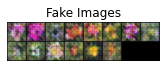

Epoch: 1, discriminator_loss= 1.444023, generator_loss= 25.677452, D(X)= 0.315617, D(G(X))= 0.132193
Epoch: 1, discriminator_loss= 1.117355, generator_loss= 25.329353, D(X)= 0.727807, D(G(X))= 0.425418
Epoch: 1, discriminator_loss= 1.135193, generator_loss= 26.232584, D(X)= 0.586389, D(G(X))= 0.357032
Epoch: 1, discriminator_loss= 0.987193, generator_loss= 24.813919, D(X)= 0.493710, D(G(X))= 0.155463
Epoch: 1, discriminator_loss= 1.301118, generator_loss= 26.226128, D(X)= 0.706961, D(G(X))= 0.513895
Epoch: 1, discriminator_loss= 0.997723, generator_loss= 24.905205, D(X)= 0.472929, D(G(X))= 0.150122
Epoch: 1, discriminator_loss= 1.325915, generator_loss= 25.206818, D(X)= 0.583666, D(G(X))= 0.445828
Epoch: 1, discriminator_loss= 0.894198, generator_loss= 25.558096, D(X)= 0.585155, D(G(X))= 0.203634
Epoch: 1, discriminator_loss= 0.940369, generator_loss= 25.467442, D(X)= 0.697209, D(G(X))= 0.351558
Epoch: 1, discriminator_loss= 0.963966, generator_loss= 25.543995, D(X)= 0.601444, D(G(X))=

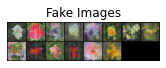

Epoch: 2, discriminator_loss= 1.863587, generator_loss= 24.378456, D(X)= 0.177757, D(G(X))= 0.075000
Epoch: 2, discriminator_loss= 1.414277, generator_loss= 25.710020, D(X)= 0.778704, D(G(X))= 0.582748
Epoch: 2, discriminator_loss= 1.331425, generator_loss= 24.455994, D(X)= 0.373491, D(G(X))= 0.231701
Epoch: 2, discriminator_loss= 1.371941, generator_loss= 24.683578, D(X)= 0.609056, D(G(X))= 0.505043
Epoch: 2, discriminator_loss= 1.117347, generator_loss= 25.118729, D(X)= 0.514424, D(G(X))= 0.300628
Epoch: 2, discriminator_loss= 1.253201, generator_loss= 24.550667, D(X)= 0.541224, D(G(X))= 0.399692
Epoch: 2, discriminator_loss= 1.432917, generator_loss= 24.456598, D(X)= 0.409535, D(G(X))= 0.378152
Epoch: 2, discriminator_loss= 1.444040, generator_loss= 26.153803, D(X)= 0.737006, D(G(X))= 0.592462
Epoch: 2, discriminator_loss= 1.915966, generator_loss= 25.004797, D(X)= 0.159939, D(G(X))= 0.067457
Epoch: 2, discriminator_loss= 1.385134, generator_loss= 24.605511, D(X)= 0.613798, D(G(X))=

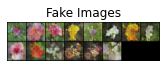

Epoch: 3, discriminator_loss= 0.777801, generator_loss= 26.502262, D(X)= 0.825434, D(G(X))= 0.322504
Epoch: 3, discriminator_loss= 1.152305, generator_loss= 23.995613, D(X)= 0.384043, D(G(X))= 0.107700
Epoch: 3, discriminator_loss= 1.101959, generator_loss= 23.798641, D(X)= 0.765606, D(G(X))= 0.462876
Epoch: 3, discriminator_loss= 1.039896, generator_loss= 24.733200, D(X)= 0.496122, D(G(X))= 0.237813
Epoch: 3, discriminator_loss= 1.095521, generator_loss= 25.624956, D(X)= 0.703477, D(G(X))= 0.439788
Epoch: 3, discriminator_loss= 1.002501, generator_loss= 24.846415, D(X)= 0.465497, D(G(X))= 0.167141
Epoch: 3, discriminator_loss= 1.173903, generator_loss= 24.220530, D(X)= 0.550501, D(G(X))= 0.377863
Epoch: 3, discriminator_loss= 1.472161, generator_loss= 25.099808, D(X)= 0.434898, D(G(X))= 0.426097
Epoch: 3, discriminator_loss= 1.077295, generator_loss= 25.516062, D(X)= 0.663884, D(G(X))= 0.403912
Epoch: 3, discriminator_loss= 1.251235, generator_loss= 24.695477, D(X)= 0.389875, D(G(X))=

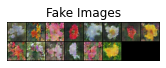

Epoch: 4, discriminator_loss= 1.131740, generator_loss= 24.861048, D(X)= 0.762115, D(G(X))= 0.474488
Epoch: 4, discriminator_loss= 0.715436, generator_loss= 24.448870, D(X)= 0.660320, D(G(X))= 0.149948
Epoch: 4, discriminator_loss= 1.669872, generator_loss= 22.364481, D(X)= 0.266716, D(G(X))= 0.262757
Epoch: 4, discriminator_loss= 1.825833, generator_loss= 26.562550, D(X)= 0.892653, D(G(X))= 0.729643
Epoch: 4, discriminator_loss= 2.087441, generator_loss= 22.765089, D(X)= 0.152453, D(G(X))= 0.046953
Epoch: 4, discriminator_loss= 1.349547, generator_loss= 23.849670, D(X)= 0.770273, D(G(X))= 0.564953
Epoch: 4, discriminator_loss= 1.048773, generator_loss= 22.911524, D(X)= 0.446664, D(G(X))= 0.176606
Epoch: 4, discriminator_loss= 0.995504, generator_loss= 24.499199, D(X)= 0.693518, D(G(X))= 0.393821
Epoch: 4, discriminator_loss= 0.821023, generator_loss= 23.452383, D(X)= 0.606753, D(G(X))= 0.205788
Epoch: 4, discriminator_loss= 0.868444, generator_loss= 23.273111, D(X)= 0.592281, D(G(X))=

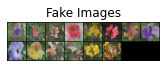

Epoch: 5, discriminator_loss= 1.633727, generator_loss= 24.033978, D(X)= 0.250341, D(G(X))= 0.194825
Epoch: 5, discriminator_loss= 1.458212, generator_loss= 26.181753, D(X)= 0.803620, D(G(X))= 0.620897
Epoch: 5, discriminator_loss= 1.437688, generator_loss= 24.940102, D(X)= 0.298620, D(G(X))= 0.157409
Epoch: 5, discriminator_loss= 0.960422, generator_loss= 24.619621, D(X)= 0.684876, D(G(X))= 0.347241
Epoch: 5, discriminator_loss= 1.125826, generator_loss= 24.996675, D(X)= 0.619559, D(G(X))= 0.390577
Epoch: 5, discriminator_loss= 0.894949, generator_loss= 24.208324, D(X)= 0.517036, D(G(X))= 0.162972
Epoch: 5, discriminator_loss= 0.864554, generator_loss= 25.006048, D(X)= 0.764519, D(G(X))= 0.341414
Epoch: 5, discriminator_loss= 0.784526, generator_loss= 24.804621, D(X)= 0.583153, D(G(X))= 0.150254
Epoch: 5, discriminator_loss= 0.928098, generator_loss= 23.867735, D(X)= 0.647809, D(G(X))= 0.307103
Epoch: 5, discriminator_loss= 0.816459, generator_loss= 24.798780, D(X)= 0.737342, D(G(X))=

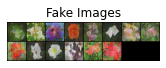

Epoch: 6, discriminator_loss= 0.864426, generator_loss= 24.222321, D(X)= 0.534641, D(G(X))= 0.140951
Epoch: 6, discriminator_loss= 0.894944, generator_loss= 24.042225, D(X)= 0.611844, D(G(X))= 0.250715
Epoch: 6, discriminator_loss= 0.980136, generator_loss= 24.208607, D(X)= 0.712515, D(G(X))= 0.382270
Epoch: 6, discriminator_loss= 0.865958, generator_loss= 24.834532, D(X)= 0.622227, D(G(X))= 0.228141
Epoch: 6, discriminator_loss= 0.959991, generator_loss= 24.891464, D(X)= 0.626869, D(G(X))= 0.286786
Epoch: 6, discriminator_loss= 1.166511, generator_loss= 23.669289, D(X)= 0.495852, D(G(X))= 0.302991
Epoch: 6, discriminator_loss= 0.999309, generator_loss= 24.988003, D(X)= 0.688772, D(G(X))= 0.382502
Epoch: 6, discriminator_loss= 1.113129, generator_loss= 24.135544, D(X)= 0.458615, D(G(X))= 0.220611
Epoch: 6, discriminator_loss= 1.050649, generator_loss= 25.660305, D(X)= 0.790972, D(G(X))= 0.453398
Epoch: 6, discriminator_loss= 1.272825, generator_loss= 23.543875, D(X)= 0.337099, D(G(X))=

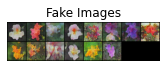

Epoch: 7, discriminator_loss= 0.992508, generator_loss= 24.784508, D(X)= 0.772108, D(G(X))= 0.386778
Epoch: 7, discriminator_loss= 0.778078, generator_loss= 25.313061, D(X)= 0.730393, D(G(X))= 0.265720
Epoch: 7, discriminator_loss= 1.398655, generator_loss= 23.414227, D(X)= 0.318283, D(G(X))= 0.153094
Epoch: 7, discriminator_loss= 1.492416, generator_loss= 26.532187, D(X)= 0.898811, D(G(X))= 0.627694
Epoch: 7, discriminator_loss= 0.781307, generator_loss= 24.951485, D(X)= 0.539545, D(G(X))= 0.068226
Epoch: 7, discriminator_loss= 0.794927, generator_loss= 24.066265, D(X)= 0.586741, D(G(X))= 0.154106
Epoch: 7, discriminator_loss= 0.964607, generator_loss= 25.515539, D(X)= 0.762173, D(G(X))= 0.392726
Epoch: 7, discriminator_loss= 0.933649, generator_loss= 24.002575, D(X)= 0.544425, D(G(X))= 0.183063
Epoch: 7, discriminator_loss= 1.019230, generator_loss= 23.862659, D(X)= 0.602397, D(G(X))= 0.303898
Epoch: 7, discriminator_loss= 0.910705, generator_loss= 23.988773, D(X)= 0.633633, D(G(X))=

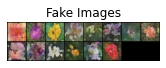

Epoch: 8, discriminator_loss= 0.808301, generator_loss= 24.751154, D(X)= 0.570821, D(G(X))= 0.137537
Epoch: 8, discriminator_loss= 0.871282, generator_loss= 23.528587, D(X)= 0.620178, D(G(X))= 0.233352
Epoch: 8, discriminator_loss= 0.856937, generator_loss= 23.912540, D(X)= 0.673266, D(G(X))= 0.276023
Epoch: 8, discriminator_loss= 0.660528, generator_loss= 26.862947, D(X)= 0.872740, D(G(X))= 0.249123
Epoch: 8, discriminator_loss= 0.913580, generator_loss= 24.947281, D(X)= 0.492481, D(G(X))= 0.079399
Epoch: 8, discriminator_loss= 0.918649, generator_loss= 25.438427, D(X)= 0.835980, D(G(X))= 0.393766
Epoch: 8, discriminator_loss= 0.798100, generator_loss= 25.205315, D(X)= 0.571662, D(G(X))= 0.129900
Epoch: 8, discriminator_loss= 0.918080, generator_loss= 23.690317, D(X)= 0.615647, D(G(X))= 0.266233
Epoch: 8, discriminator_loss= 1.090575, generator_loss= 23.921389, D(X)= 0.593760, D(G(X))= 0.368632
Epoch: 8, discriminator_loss= 0.711416, generator_loss= 25.602999, D(X)= 0.797108, D(G(X))=

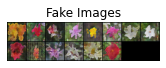

Epoch: 9, discriminator_loss= 1.057247, generator_loss= 27.956980, D(X)= 0.936722, D(G(X))= 0.465286
Epoch: 9, discriminator_loss= 0.880742, generator_loss= 24.938490, D(X)= 0.487445, D(G(X))= 0.054679
Epoch: 9, discriminator_loss= 0.763234, generator_loss= 23.872574, D(X)= 0.681604, D(G(X))= 0.197224
Epoch: 9, discriminator_loss= 0.744257, generator_loss= 26.392319, D(X)= 0.834621, D(G(X))= 0.289157
Epoch: 9, discriminator_loss= 0.646314, generator_loss= 25.867018, D(X)= 0.646304, D(G(X))= 0.085470
Epoch: 9, discriminator_loss= 0.617101, generator_loss= 26.091990, D(X)= 0.818160, D(G(X))= 0.190595
Epoch: 9, discriminator_loss= 0.656289, generator_loss= 25.410255, D(X)= 0.704256, D(G(X))= 0.149575
Epoch: 9, discriminator_loss= 0.765910, generator_loss= 23.761831, D(X)= 0.645485, D(G(X))= 0.186297
Epoch: 9, discriminator_loss= 0.840027, generator_loss= 25.692129, D(X)= 0.756868, D(G(X))= 0.316931
Epoch: 9, discriminator_loss= 0.755116, generator_loss= 25.138571, D(X)= 0.645419, D(G(X))=

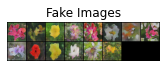

In [24]:
Generator_losses = []
Discriminator_losses = []
dcganmodel = DCGAN(0.0002, 64, 10, None, None)
dcganmodel.train_dcgan()

**DCGAN Tester On Training Data**

In [25]:
dcganmodel.train_predict()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


these flowers have smooth delicate white and purple petals attached to a green pedicel.

the peach colored petals overlap around this flower and bend outwards.

the flower has yellow petals that are oval shaped with a cup in the middle.

this flower is yellow and black in color, with petals that are oval shaped and layered.


this flower has large white petals and a lot of yellow stamen


this flower has petals that are pink with large style

this flower has large wavy petals that are very dark purple in color with some yellow markings.

the flower has petals that are small and dark orange.

the flower has small round petals that are orange in color with thick green stems.

this flower is orange in color, and has petals that are wavy.

this flower has light blue petals in a funnel-type of shape with wrinkled edges.

the flowers has a set of 6 brightly colored orange petals.


this flower has petals that are pink and has yellow stamen

this flower is white in color, with petals that are

**DCGAN Tester On Validation Data**

In [26]:
dcganmodel.val_predict()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



this flower has petals that are pink and are very thin

this flower is purple in color, and has petals that are shaped like bulbs.

the petals are purple in color with a few splashes of white.


this flower has pink petals that are folded together and go upwards

this flower has bunches of bell-shaped petals with white tips.

the flower had a large pink bloom that is made of pink petals that have ruffled edges.

this flower is pink in color, and has petals that are curled and wavy.

the petals of this flower are light pink with jagged edges.

this flower has thick purple and green sepals, smaller white petals, and lots of think purple filaments.

this flower has small pink petals whose edges are deeply serrated.

the flower has a long green pedicel and many small purple petals.

this flower is purple and white in color, with petals that are multi colored.

this flower has petals that are white and light purple.

this flower has a single row of dark purple petals with a white border an

**DCGAN Tester On Testing Data**

In [27]:
dcganmodel.test_predict()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



this flower has petals that are pink with red steman

this flower has white petals with yellow and brownish purple stripes.

this is a cluster of flowers with yellowish white petals and no visible pistils.


this flower has petals that are yellow with red stamen


this flower has petals that are purple and are very thin


a flower with broad yellow and black striped petals, green sepals, and green pedicel

this flower is pink and white in color, with oval shaped petals.

this flower has a few amount of petals that are a very dark shade of purple.

this flower has a cactus like appearance on the bottom and numerous amount of tiny pink petals sticking out of the top.


pedicels are green in color,flower is purple in color with rounded petals

this flower has spike like orange and purple petals and a green pedicel, sepal, and receptacle.

a four petaled flower that is light lavender with a yellow center and many white anther in the center.


this flower has petals that are orange and has

**Plotting Results Of Generated Images From Test Data**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


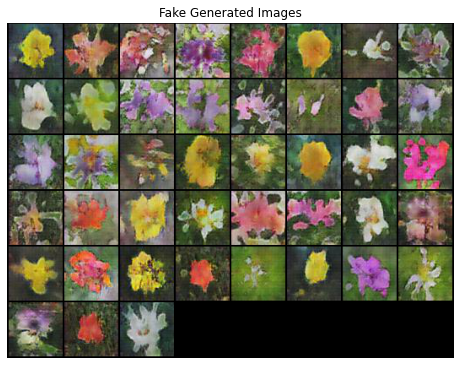

In [28]:
dataroot = "/content/drive/MyDrive/TTI/results/Testing/"
plotdataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(plotdataset, batch_size=64,
                                         shuffle=True, num_workers=4)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Generated Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**Plotting Generator And Discriminator Loss During Training**

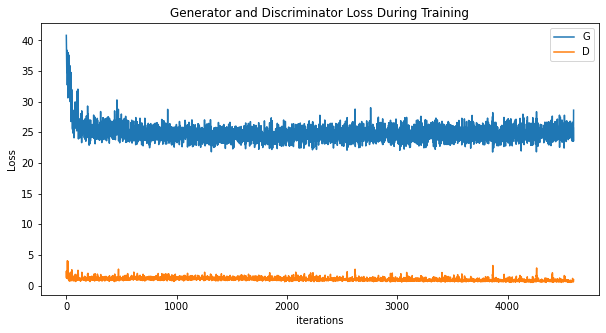

In [29]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Generator_losses,label="G")
plt.plot(Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()